#**Implementation of an Attention Model with Bi-LSTM**

Python implementation of the attention model with bi-LSTM using Keras. 

Source paper can be found [here](https://arxiv.org/pdf/1409.0473.pdf). A high level diagram of the model can be seen [here](https://jscriptcoder.github.io/date-translator/attn_mechanism.png).





1. Generate the data for testing the efficiency using random numbers

In [102]:
from random import randint
from numpy import array
from numpy import argmax

# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(0, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)
 
 # decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_pair(n_in, n_out, n_unique):
	# generate random sequence
	sequence_in = generate_sequence(n_in, n_unique)
	sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
	# one hot encode
	seq_input = one_hot_encode(sequence_in, n_unique)
	seq_output = one_hot_encode(sequence_out, n_unique)
	# reshape as 3D
	seq_input = seq_input.reshape((1, seq_input.shape[0], seq_input.shape[1]))
	seq_output = seq_output.reshape((1, seq_output.shape[0], seq_output.shape[1]))
	return seq_input,seq_output

2. Add the implementation of the model

In [133]:
import tensorflow as tf
import numpy as np
import keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Bidirectional,LSTM,Dense,Activation,Dot,Multiply
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# need to write a custom softmax function as we want it to be used by attention weights & inputs
def softmax(x, axis=1):
  ndim = K.ndim(x)
  if ndim == 2:
      return K.softmax(x)
  elif ndim > 2:
      e = K.exp(x - K.max(x, axis=axis, keepdims=True))
      s = K.sum(e, axis=axis, keepdims=True)
      return e / s
  else:
      raise ValueError('Cannot apply softmax to a tensor that is 1D')

class AttentionModel:
  def __init__(self,**kwargs):
    self.__dict__.update(kwargs)
    
  def create(self):
    X = Input(shape=(self.pre_attention_output_units, self.input_features))
    activations = Bidirectional(LSTM(self.input_features,return_sequences=True),input_shape=self.input_shape)(X)
    outputs = []
    post_activation_LSTM = LSTM(self.input_features, return_sequences=True)
    post_activation_dense_layer = Dense(self.input_features, activation=softmax)
    self.activator = Activation(softmax,name='attention_weights')
    all_contexts=[]
    for i in range(self.output_cell_size):
      context = self.compute_context(input=activations)
      all_contexts.append(context)
    
    contexts = all_contexts[0]    
    for i in range(1,len(all_contexts)):
      contexts = tf.keras.layers.concatenate([contexts,all_contexts[i]],axis=1)
    
    s = post_activation_LSTM(contexts)
    out = post_activation_dense_layer(s)
    outputs.append(out)
    self.model = Model(inputs=X,outputs=outputs)
    opt = Adam(learning_rate=0.005,beta_1=0.9,beta_2=0.999,decay=0.01)
    self.model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    self.model.summary()
    plot_model(self.model, to_file='model.png', show_shapes=True)
  
  def compute_context(self,input):
    output_1 = Dense(self.hidden_dense_units, activation='tanh')(input)
    output_2 = Dense(1, activation='relu')(output_1)
    alphas = self.activator(output_2)
    context = Dot(axes=1)([alphas,input])
    return context
  
  def train(self,Xin,Yout,epochs,batch_size):
    self.model.fit(Xin, Yout, epochs=epochs, verbose=0, batch_size=batch_size)

  def predict(self,Xin):
    return self.model.predict(Xin)


3. Add the code for generating the input dataset.

In [126]:
# configure problem
n_features = 10
n_timesteps_in = 5
n_timesteps_out = 3
m = 5000
Tx = 5
hidden_dense_units = 10

X = np.zeros(shape=(m,Tx,n_features))
Y = np.zeros(shape=(m,Tx,n_features))

# generate new random sequence and push them to the dataset
for epoch in range(m):
  x,y = get_pair(n_timesteps_in,n_timesteps_out,n_features)
  X[epoch] = x
  Y[epoch] = y

4. Create and train the model.


In [134]:
attention_model = AttentionModel(m=m,input_shape=(m,Tx,n_features*2),pre_attention_output_units=n_timesteps_in,hidden_dense_units=hidden_dense_units,hidden_state_size_LSTM=n_timesteps_in,output_cell_size=Tx,input_features=n_features)
attention_model.create()

# train the model
attention_model.train(X,Y,epochs=3000,batch_size=100)


Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 5, 10)]      0                                            
__________________________________________________________________________________________________
bidirectional_25 (Bidirectional (None, 5, 20)        1680        input_26[0][0]                   
__________________________________________________________________________________________________
dense_276 (Dense)               (None, 5, 10)        210         bidirectional_25[0][0]           
__________________________________________________________________________________________________
dense_278 (Dense)               (None, 5, 10)        210         bidirectional_25[0][0]           
___________________________________________________________________________________________

The model created is stored as `model.ppg`. It can be seen as 

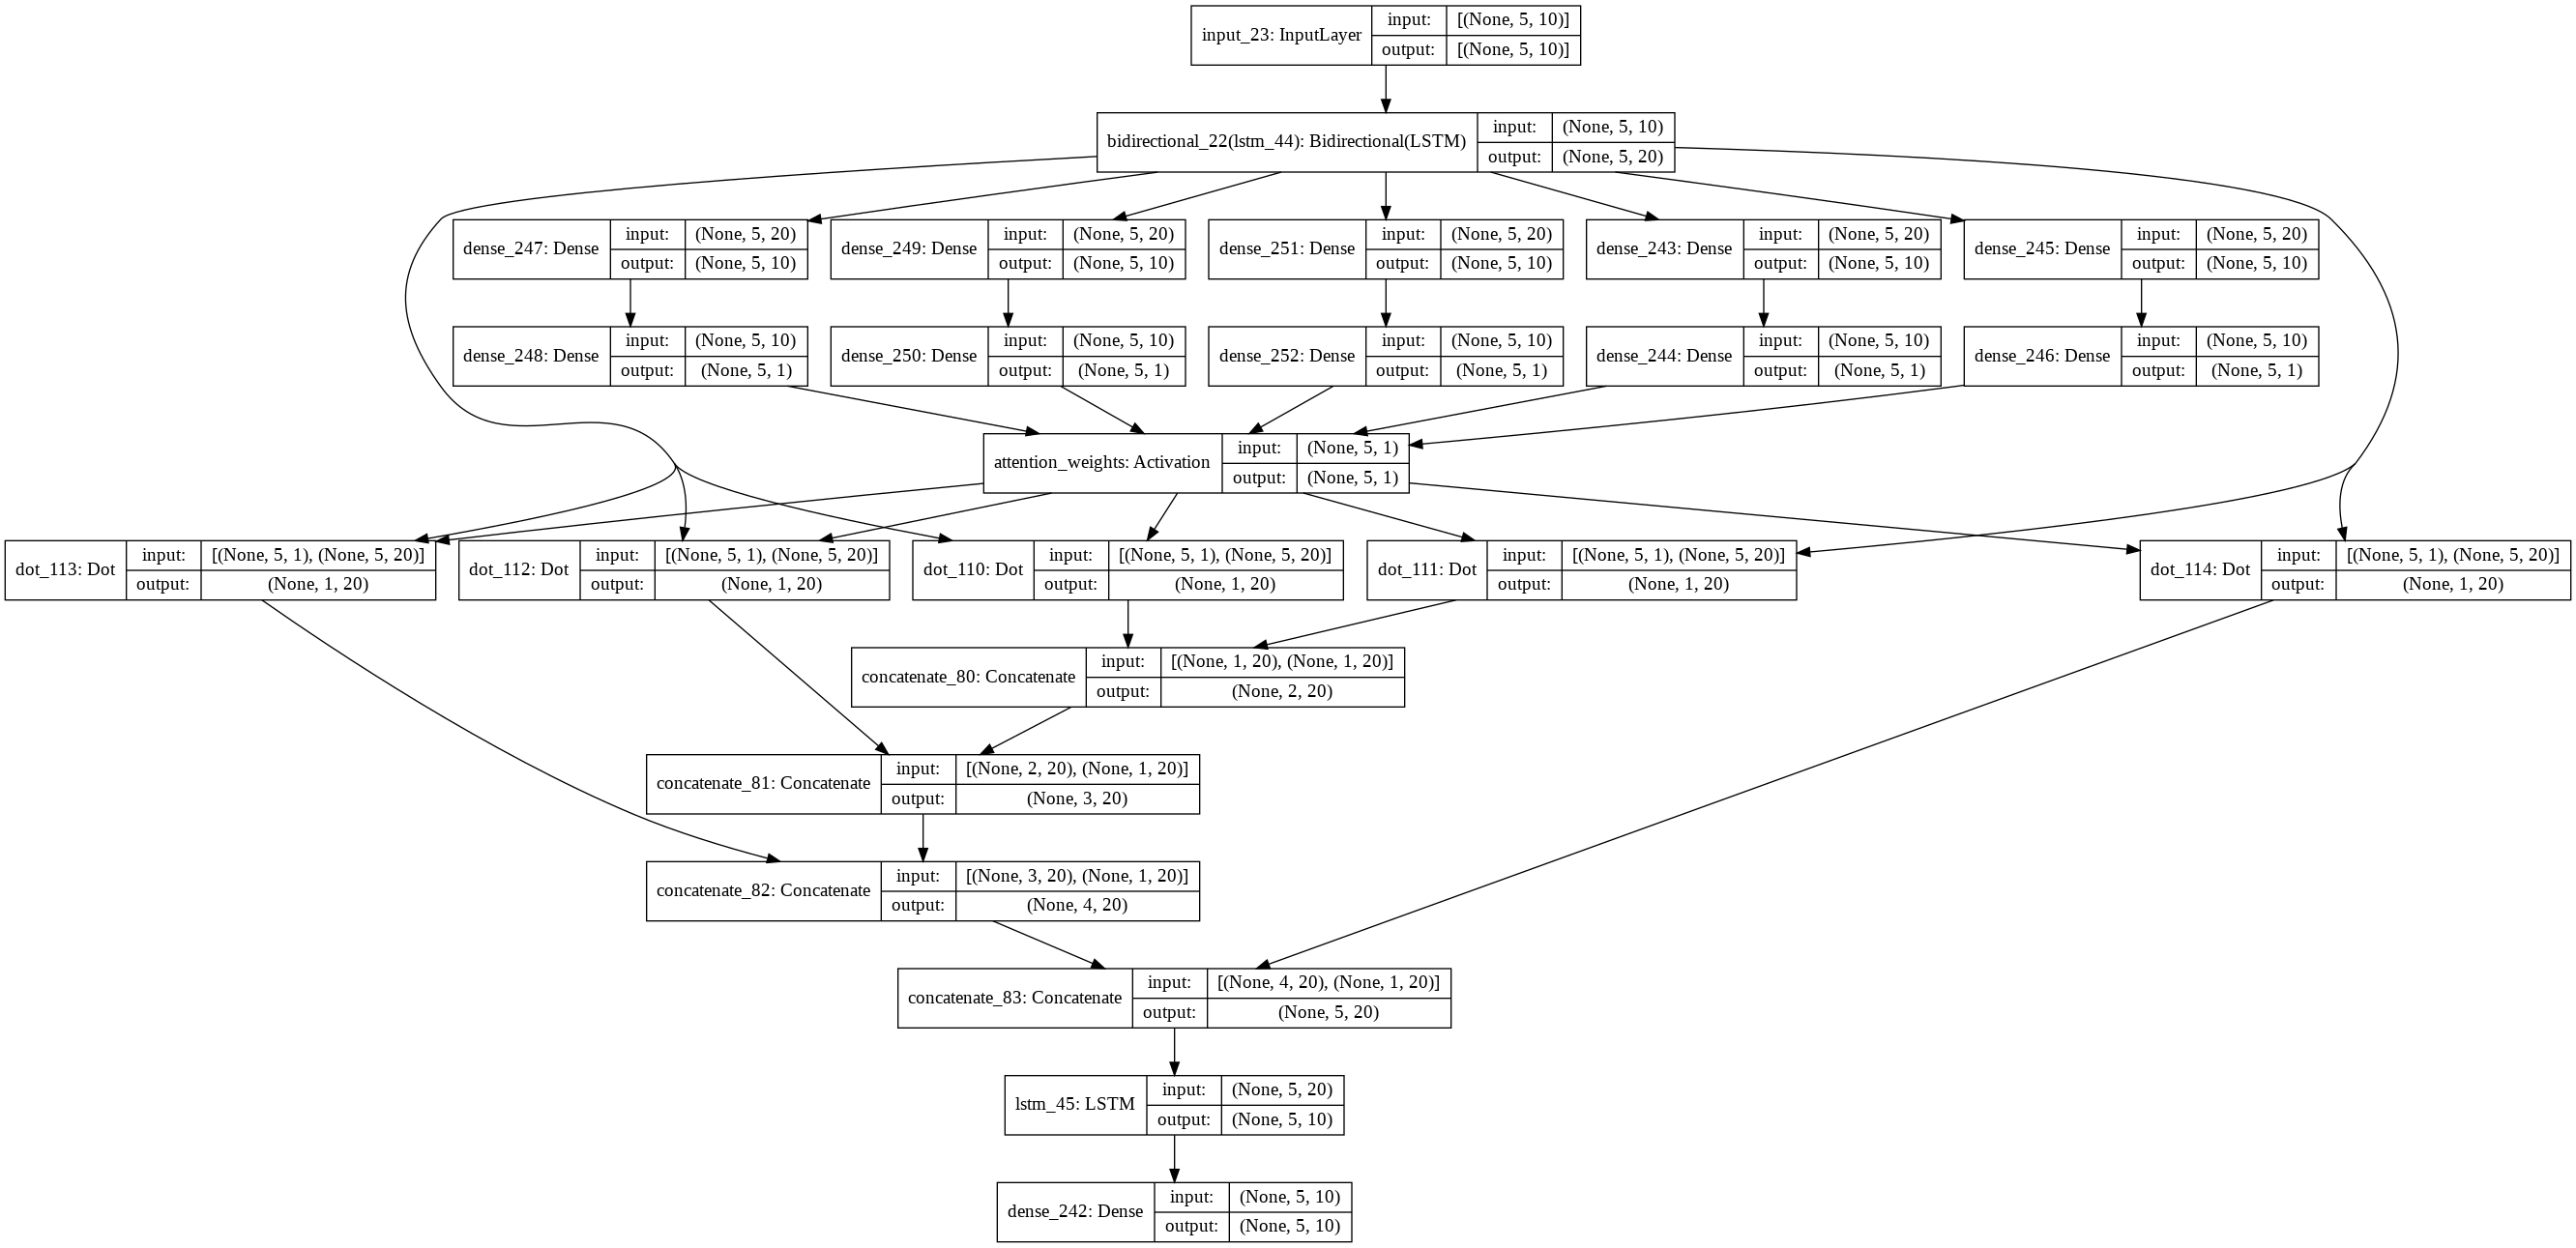

5. Check the accuracy of the attention model

In [ ]:
# evaluate LSTM
total, correct = 100, 0

for _ in range(total):
	x,y = get_pair(n_timesteps_in,n_timesteps_out,n_features)
	yhat = attention_model.predict(x)
	if np.array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])):
		correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))